In [6]:
# Install dependencies
%pip install yfinance pandas matplotlib seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 31.2 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]m1/2 [seaborn]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Parameters for fetching stock data
# Indian stocks use suffixes like .NS (NSE) or .BO (BSE)
# ^NSEI is the ticker for Nifty 50 Index (Benchmark)
stock_symbols = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS', 
    'ICICIBANK.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'WIPRO.NS', 'HCLTECH.NS'
]
benchmark_symbol = '^NSEI'
all_symbols = stock_symbols + [benchmark_symbol]

start_date = '2024-01-01' # Using a full year for better metrics
end_date = '2024-12-31'

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch historical data for all symbols
print(f"Downloading data for {len(all_symbols)} symbols...")
data = yf.download(all_symbols, start=start_date, end=end_date, progress=False)

# Extract Close prices
all_close = data['Close']

# Separate stock prices and benchmark prices
stock_prices = all_close[stock_symbols].dropna()
benchmark_prices = all_close[benchmark_symbol].dropna()

# Synchronize data (ensure they have the same index)
common_index = stock_prices.index.intersection(benchmark_prices.index)
stock_prices = stock_prices.loc[common_index]
benchmark_prices = benchmark_prices.loc[common_index]

print(f"Fetched {len(stock_prices)} rows of data.")
stock_prices.head()

Fetched 245 rows of data.


Ticker,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,SBIN.NS,ICICIBANK.NS,AXISBANK.NS,KOTAKBANK.NS,WIPRO.NS,HCLTECH.NS
Date,,,,,,,,,,
2024-01-01,1285.609741,3549.363037,826.441040,1460.572510,618.355835,983.282715,1095.916748,380.972717,223.164429,1370.048218
2024-01-02,1296.255859,3523.379150,826.927734,1444.614380,616.523987,966.409241,1091.474121,372.172516,219.446182,1356.936401
2024-01-03,1282.160156,3438.209717,814.176575,1402.812622,620.380554,968.180298,1096.815430,372.342133,213.225739,1327.573242
2024-01-04,1288.786011,3414.973389,822.912598,1424.183960,619.705627,971.230286,1121.575195,371.883179,211.588776,1311.137085
2024-01-05,1294.270508,3481.190186,818.702759,1442.872559,618.934387,977.674622,1135.103027,368.690338,213.553146,1323.002686


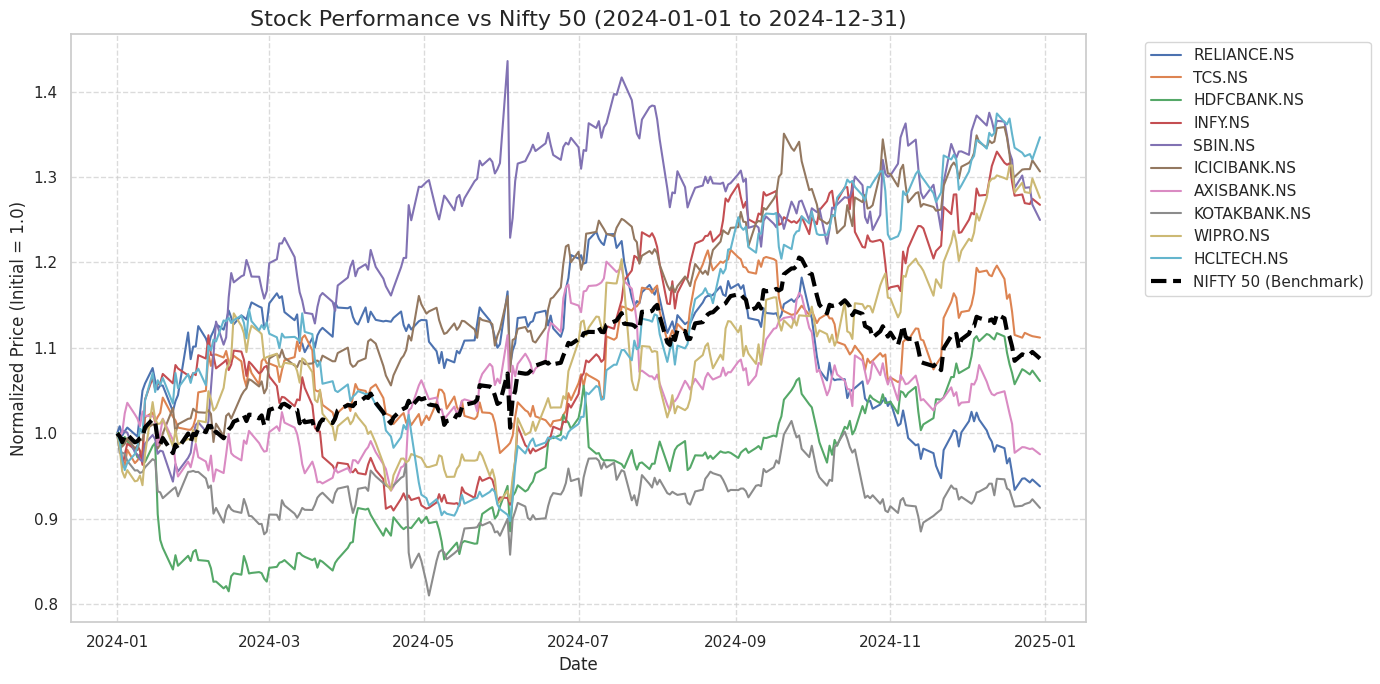

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")

# Normalize the prices: Price / Initial Price
normalized_data = stock_prices / stock_prices.iloc[0]

# Visualize the normalized Close prices
plt.figure(figsize=(14, 7))
for symbol in stock_symbols:
    plt.plot(normalized_data[symbol], label=symbol)

# Also plot the benchmark for comparison
normalized_benchmark = benchmark_prices / benchmark_prices.iloc[0]
plt.plot(normalized_benchmark, label='NIFTY 50 (Benchmark)', color='black', linewidth=3, linestyle='--')

plt.title(f'Stock Performance vs Nifty 50 ({start_date} to {end_date})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price (Initial = 1.0)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Advanced KPI Calculations
from scipy import stats

# 1. Basic Returns
daily_returns = stock_prices.pct_change().dropna()
bench_returns = benchmark_prices.pct_change().dropna()
total_return = (stock_prices.iloc[-1] / stock_prices.iloc[0] - 1) * 100

# 2. Annualized Volatility
volatility = daily_returns.std() * np.sqrt(252) * 100

# 3. Sharpe Ratio (Risk-free rate = 6%)
rf_daily = 0.06 / 252
excess_returns = daily_returns.sub(rf_daily, axis=0)
sharpe_ratio = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))

# 4. Maximum Drawdown
def calculate_max_drawdown(prices):
    roll_max = prices.cummax()
    drawdown = (prices - roll_max) / roll_max
    return drawdown.min() * 100

max_drawdown = stock_prices.apply(calculate_max_drawdown)

# 5. Beta Calculation
def calculate_beta(stock_ret, bench_ret):
    # Align returns
    common = stock_ret.index.intersection(bench_ret.index)
    s = stock_ret.loc[common]
    b = bench_ret.loc[common]
    
    covariance = np.cov(s, b)[0][1]
    variance = np.var(b)
    return covariance / variance

beta = pd.Series({symbol: calculate_beta(daily_returns[symbol], bench_returns) for symbol in stock_symbols})

# Create Dashboard DataFrame
dashboard_kpis = pd.DataFrame({
    'Total Return (%)': total_return,
    'Annualized Volatility (%)': volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown (%)': max_drawdown,
    'Beta': beta
})

print("Dashboard KPIs Table:")
dashboard_kpis.sort_values(by='Sharpe Ratio', ascending=False)

Dashboard KPIs Table:


,Total Return (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%),Beta
HCLTECH.NS,34.661162,22.355788,1.218407,-21.664495,0.679343
ICICIBANK.NS,30.657940,20.821069,1.143063,-8.625643,0.958823
INFY.NS,26.745820,22.913881,0.920420,-18.398912,0.697777
WIPRO.NS,27.568986,28.029391,0.823281,-19.530389,1.061667
SBIN.NS,24.973808,29.397848,0.728587,-15.132780,1.436902
TCS.NS,11.209944,21.170533,0.339806,-12.735202,0.647708
HDFCBANK.NS,6.129091,22.449258,0.119430,-18.542167,0.993489
AXISBANK.NS,-2.452775,24.891599,-0.220054,-18.777044,1.115426
RELIANCE.NS,-6.201412,22.989995,-0.434049,-24.455565,1.229555
KOTAKBANK.NS,-8.723365,23.300305,-0.543988,-18.984895,0.809729


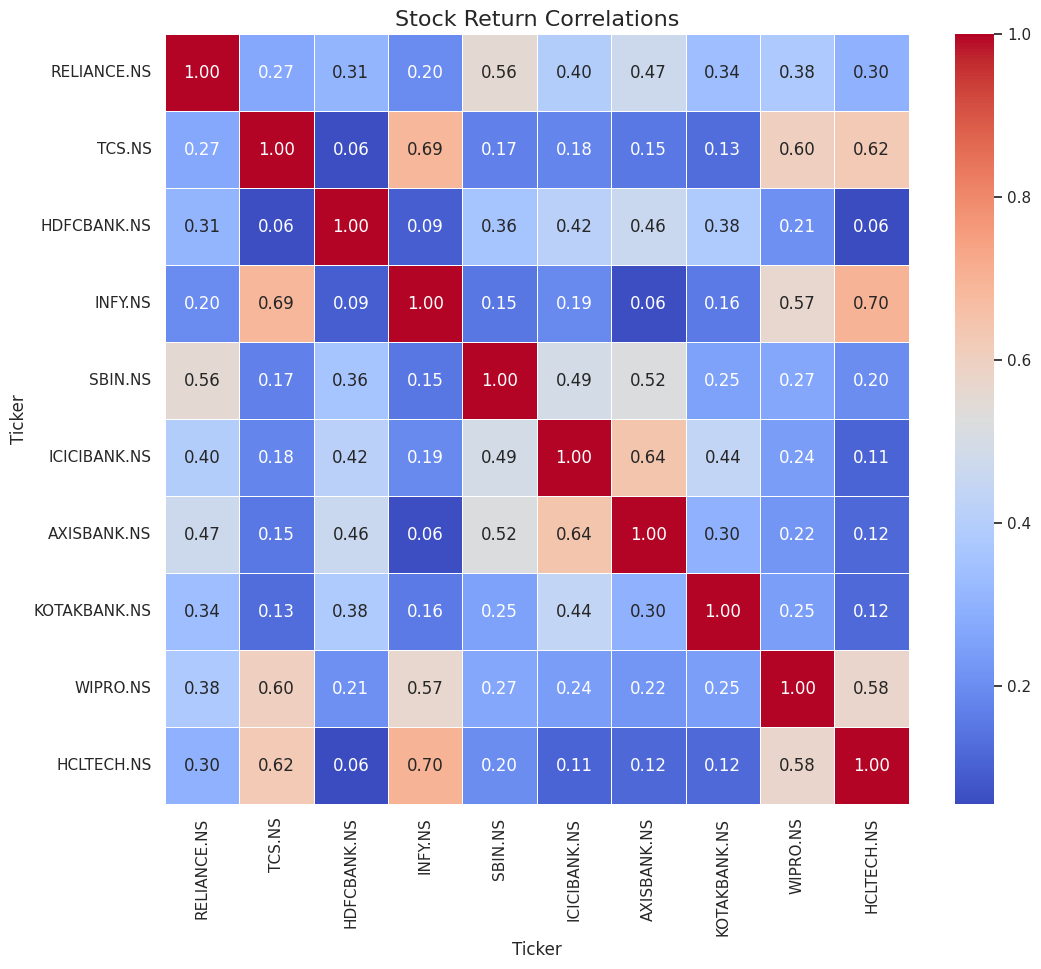

In [11]:
# 1. Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = daily_returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Stock Return Correlations', fontsize=16)
plt.show()

/usr/local/python/3.12.1/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


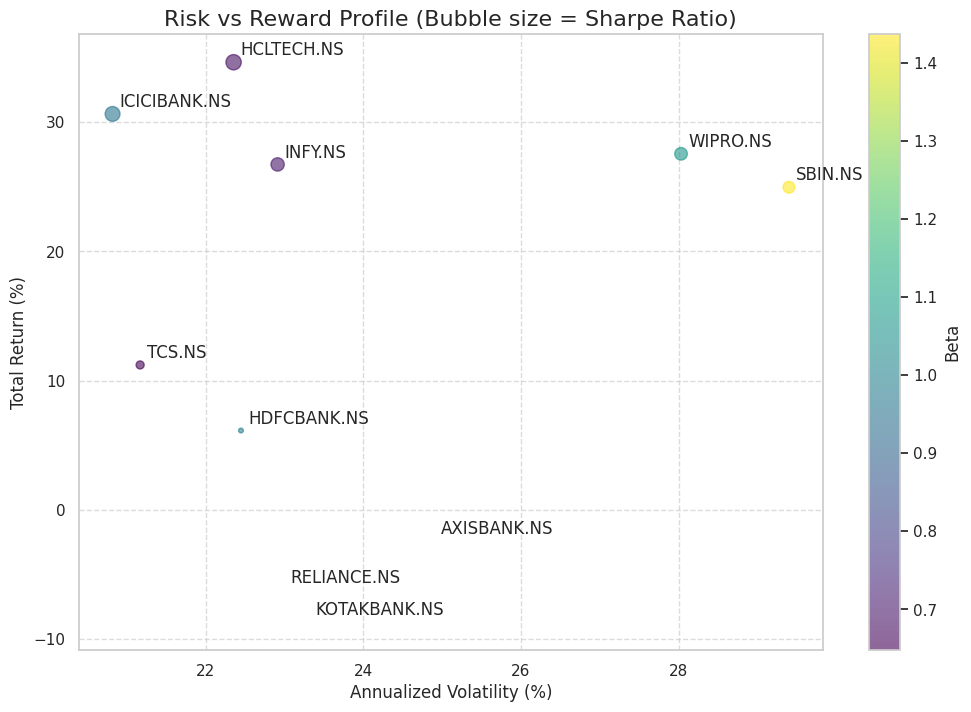

In [12]:
# 2. Risk-Reward Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(dashboard_kpis['Annualized Volatility (%)'], dashboard_kpis['Total Return (%)'], 
            s=dashboard_kpis['Sharpe Ratio']*100, alpha=0.6, c=dashboard_kpis['Beta'], cmap='viridis')

for i, txt in enumerate(dashboard_kpis.index):
    plt.annotate(txt, (dashboard_kpis['Annualized Volatility (%)'].iloc[i], dashboard_kpis['Total Return (%)'].iloc[i]), 
                 xytext=(5,5), textcoords='offset points')

plt.colorbar(label='Beta')
plt.title('Risk vs Reward Profile (Bubble size = Sharpe Ratio)', fontsize=16)
plt.xlabel('Annualized Volatility (%)', fontsize=12)
plt.ylabel('Total Return (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()